In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

This model uses data from the [UCI ML Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)

In [6]:
from ucimlrepo import fetch_ucirepo

diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)
print(f"\nVariable Information:\n{diabetes_130_us_hospitals_for_years_1999_2008.variables}")


Variable Information:
                        name     role         type demographic  \
0               encounter_id       ID                     None   
1                patient_nbr       ID                     None   
2                       race  Feature  Categorical        Race   
3                     gender  Feature  Categorical      Gender   
4                        age  Feature  Categorical         Age   
5                     weight  Feature  Categorical        None   
6          admission_type_id  Feature  Categorical        None   
7   discharge_disposition_id  Feature  Categorical        None   
8        admission_source_id  Feature  Categorical        None   
9           time_in_hospital  Feature      Integer        None   
10                payer_code  Feature  Categorical        None   
11         medical_specialty  Feature  Categorical        None   
12        num_lab_procedures  Feature      Integer        None   
13            num_procedures  Feature      Integer   

/opt/anaconda3/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [7]:
data = pd.read_csv("diabetes_data/diabetic_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [8]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
data["patient_nbr"].nunique()

71518

In total there are 101766 entries but only 71518 patients. Need to stratify split training and testing by patient ID (patient_nbr column)
### Part 1: Exploratory Data Analysis
Examine numerical and categorical columns separately

In [11]:
diabetes_130_us_hospitals_for_years_1999_2008.variables.columns

Index(['name', 'role', 'type', 'demographic', 'description', 'units',
       'missing_values'],
      dtype='object')

In [12]:
# separate numerical and categorical columns
features_info = diabetes_130_us_hospitals_for_years_1999_2008.variables
num_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,2] == "Integer")]
cat_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,2] == "Categorical")]
print(f"Numerical Columns:\n{num_cols}")
print(f"Categorical Columns:\n{cat_cols}")

Numerical Columns:
['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical Columns:
['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


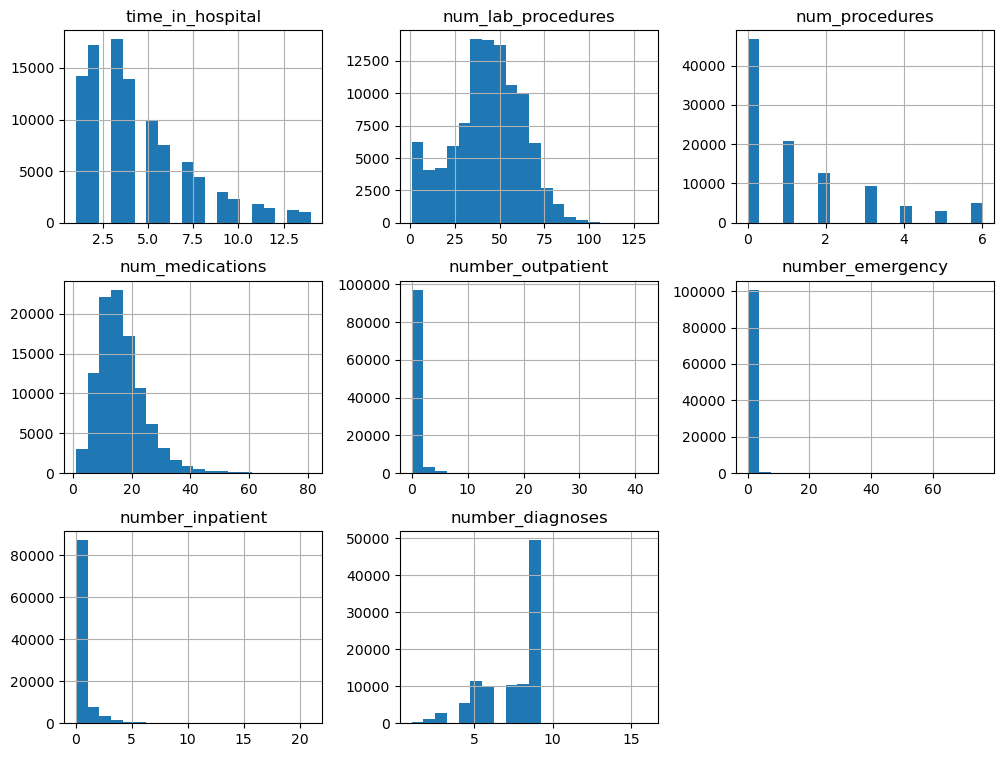

In [13]:
# graph histograms of numerical data
data[num_cols].hist(bins = 20, figsize = (12, 9))
plt.show()

Will need to apply transformation to tail-heavy numerical features\
(i.e. time_in_hospital, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient)

### Part 2: Data Preprocessing
**First**: split the data based on patient ID (make sure the same patient is only in one dataset)\
**Second**: data preprocessing on training data. Will need to:
1. Determine how to handle missing values
2. Split training and testing data
3. Determine transformations for numerical features
4. Determine how to encode categorical features
5. Determine how to scale select numerical features
6. *Finally*: build pipeline using ColumnTransformer

**Handle Missing Values**

Find Missing Values

In [18]:
missing_cols = [features_info.iloc[i,0] for i in range(len(features_info)) if (features_info.iloc[i,6] == "yes")]
missing_cols

['race',
 'weight',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3']

In [19]:
print(f"Missing race entries: {len(data[data["race"] == "?"])} / 101766 ({round((len(data[data["race"] == "?"])) / 101766 * 100, 3)}%)")
print(f"Missing weight entries: {len(data[data["weight"] == "?"])} / 101766 ({round((len(data[data["weight"] == "?"])) / 101766 * 100, 3)}%)")
print(f"Missing payer_code entries: {len(data[data["payer_code"] == "?"])} / 101766 ({round((len(data[data["payer_code"] == "?"])) / 101766 * 100, 3)}%)")
print(f"Missing medical_specialty entries: {len(data[data["medical_specialty"] == "?"])} / 101766 ({round((len(data[data["medical_specialty"] == "?"])) / 101766 * 100, 3)}%)")
print(f"Missing diag_1 entries: {len(data[data["diag_1"] == "?"])} / 101766 ({round((len(data[data["diag_1"] == "?"])) / 101766, 5)}%)")
print(f"Missing diag_2 entries: {len(data[data["diag_2"] == "?"])} / 101766 ({round((len(data[data["diag_2"] == "?"])) / 101766 * 100, 3)}%)")
print(f"Missing diag_3 entries: {len(data[data["diag_3"] == "?"])} / 101766 ({round((len(data[data["diag_3"] == "?"])) / 101766 * 100, 3)}%)")

Missing race entries: 2273 / 101766 (2.234%)
Missing weight entries: 98569 / 101766 (96.858%)
Missing payer_code entries: 40256 / 101766 (39.557%)
Missing medical_specialty entries: 49949 / 101766 (49.082%)
Missing diag_1 entries: 21 / 101766 (0.00021%)
Missing diag_2 entries: 358 / 101766 (0.352%)
Missing diag_3 entries: 1423 / 101766 (1.398%)


Plan for missing data:
1. race: fill missing values w/ "None" (else try removing all 2273 missing instances)
2. weight: remove feature
3. payer_code: fill missing values w/ "None"
4. medical_specialty: remove feature, *consider alternative approach when optimizing model*
5. diag_1: remove the 21 missing instances
6. diag_2 and diag_3: impute with most common diagnosis code

In [21]:
# first remove weight and medical_specialty
data.drop(columns = ["weight", "medical_specialty"], axis = 1, inplace = True, errors = "ignore")
# now drop missing values for diag_1
data = data[data["diag_1"] != "?"]

**Add Feature encounter_count**

In [23]:
data["encounter_count"] = data["patient_nbr"].map(data["patient_nbr"].value_counts())
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'encounter_count'],
      dtype='object')

**Split Training & Testing Data**\
Some patients have multiple records: need to make sure each patient only appears in either training or testing data to avoid model overfitting

In [25]:
from sklearn.model_selection import GroupShuffleSplit
X = data.drop(columns = "readmitted", axis = 1, inplace = False, errors = "ignore")
y = data["readmitted"]

# split by patient id
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state = 42)
train_idx, test_idx = next(splitter.split(X, y, groups=data["patient_nbr"]))
X_train = X.iloc[train_idx].copy()
X_test = X.iloc[test_idx].copy()
y_train = y.iloc[train_idx].copy()
y_test = y.iloc[test_idx].copy()

# make sure split is corect
print(f"Unique number of patients in training data: {X_train["patient_nbr"].nunique()}")
print(f"Unique number of patients in testing data: {X_test["patient_nbr"].nunique()}")
print(f"Total number of unique patients in data: {data["patient_nbr"].nunique()}")
assert (X_train["patient_nbr"].nunique() + X_test["patient_nbr"].nunique()) == data["patient_nbr"].nunique()
X_train.drop(columns = ["encounter_id", "patient_nbr"], axis = 1, inplace = True, errors = "ignore")
X_test.drop(columns = ["encounter_id", "patient_nbr"], axis = 1, inplace = True, errors = "ignore")

Unique number of patients in training data: 57207
Unique number of patients in testing data: 14302
Total number of unique patients in data: 71509


**Transform Numerical Features**

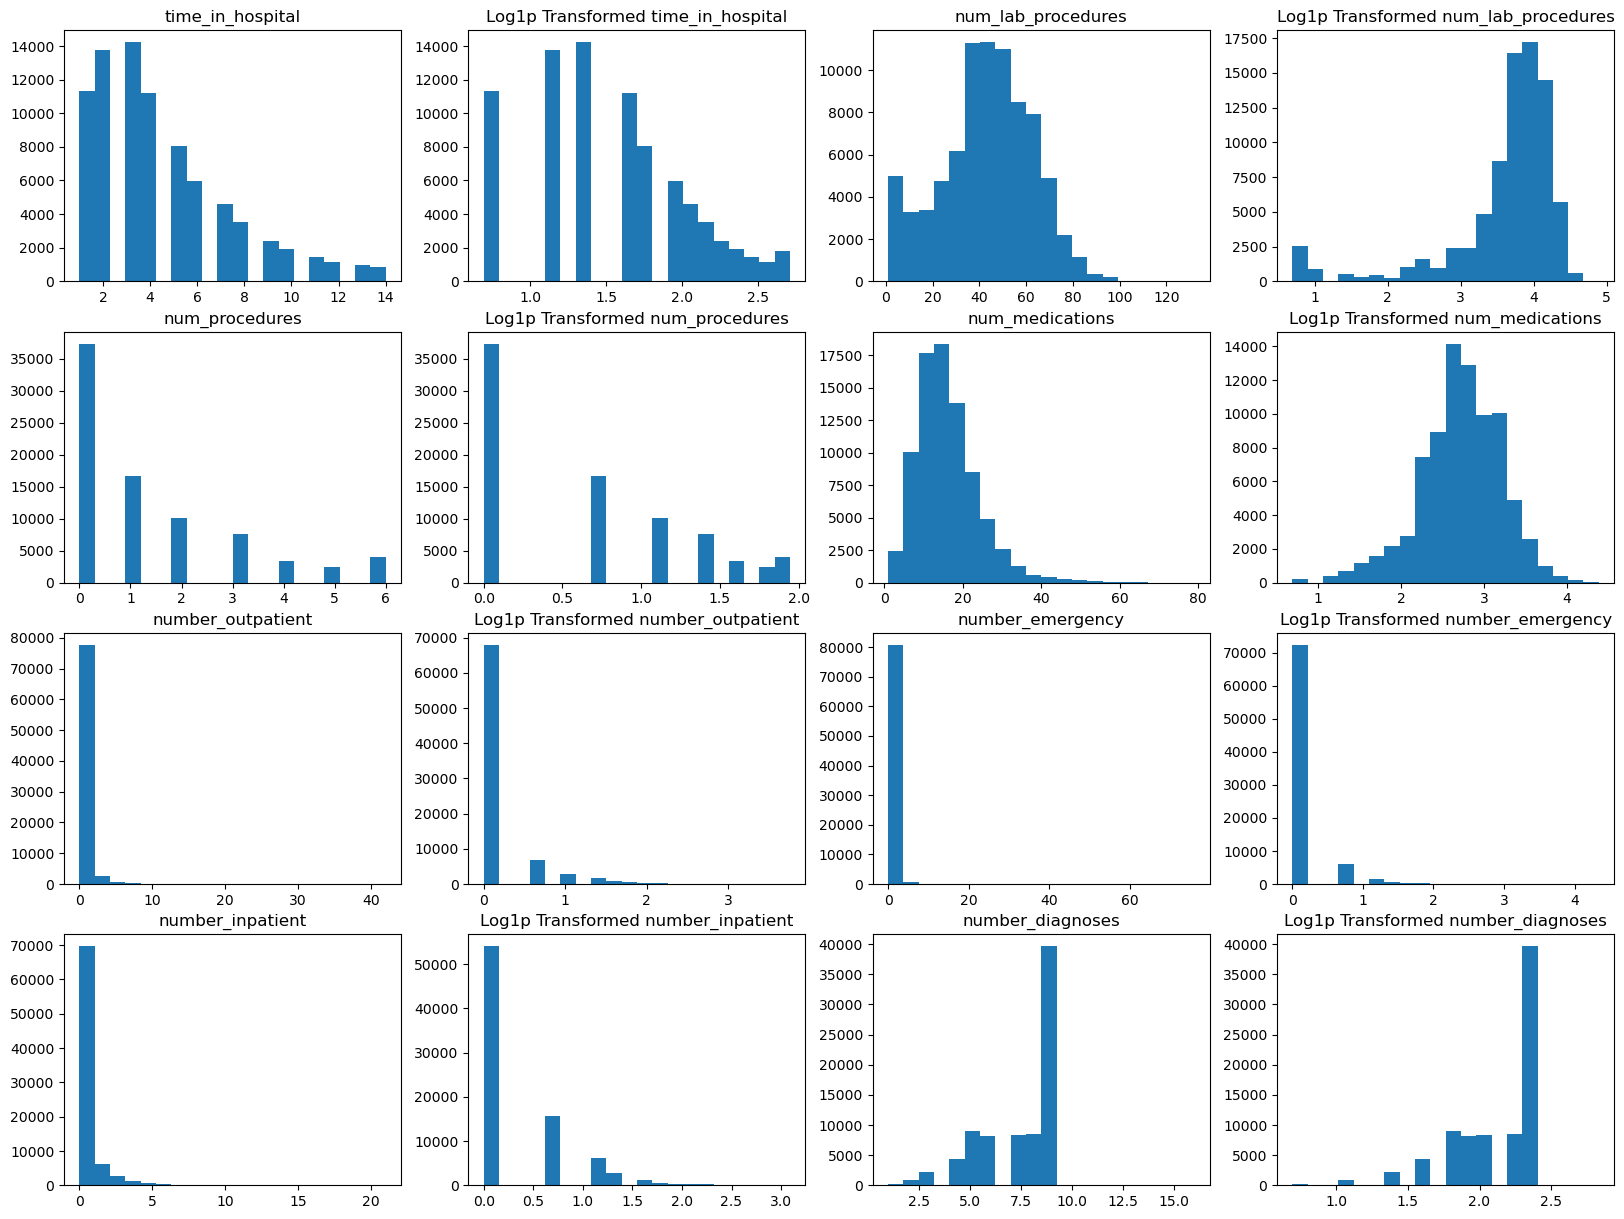

In [27]:
# try log transform (use log1p for all the 0s in the data)
# graph untransformed plots first
plt.figure(figsize = (20, 15))
for i in range(4):
    for j in range(1, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 ]
        plt.title(curr_col)
        plt.hist(X_train[curr_col], bins = 20)
# graph transformd plots
for i in range(4):
    for j in range(2, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 - 1]
        plt.title("Log1p Transformed " + curr_col)
        plt.hist(np.log1p(X_train[curr_col]), bins = 20)
plt.show()

In [28]:
# try quantile transform
from sklearn.preprocessing import QuantileTransformer
qt_test = QuantileTransformer(output_distribution = "normal", random_state = 42)
X_train_num_transformed = qt_test.fit_transform(X_train[num_cols])

In [29]:
X_train_num_transformed

array([[-5.19933758, -0.17400458, -5.19933758, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.25749484,  0.78332986, -5.19933758, ..., -5.19933758,
        -5.19933758,  0.68634989],
       [-0.73973722, -1.36845029,  1.4979966 , ..., -5.19933758,
         0.69590794, -0.65648594],
       ...,
       [-5.19933758,  0.47521374, -5.19933758, ..., -5.19933758,
        -5.19933758,  3.02303869],
       [ 1.47155479,  0.07157147,  0.58052362, ..., -5.19933758,
         0.69590794,  0.68634989],
       [ 0.68634989, -1.30119068,  0.93974701, ..., -5.19933758,
        -5.19933758,  0.68634989]])

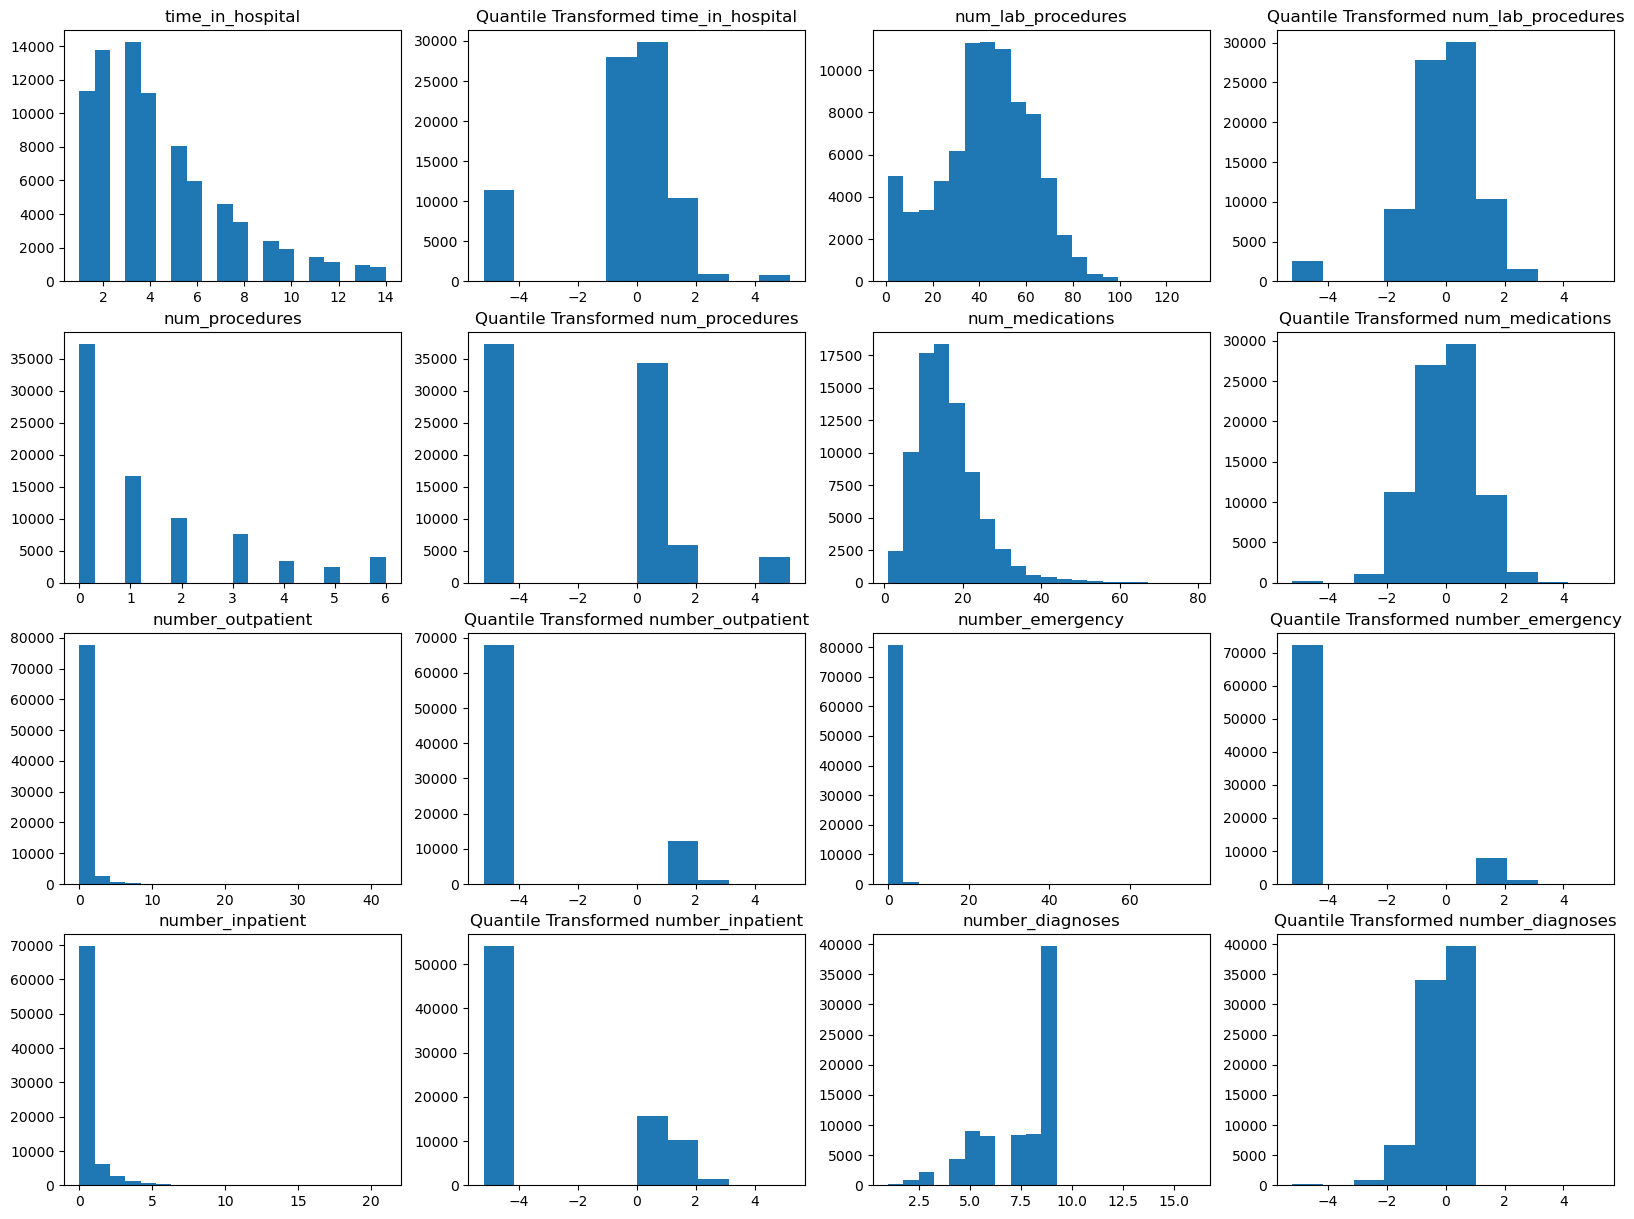

In [30]:
# graph untransformed plots first
plt.figure(figsize = (20, 15))
for i in range(4):
    for j in range(1, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 ]
        plt.title(curr_col)
        plt.hist(X_train[curr_col], bins = 20)
# graph transformd plots
for i in range(4):
    for j in range(2, 5, 2):
        plt.subplot(4, 4, (i * 4 + j))
        curr_col = num_cols[(i * 4 + j) // 2 - 1]
        plt.title("Quantile Transformed " + curr_col)
        plt.hist(X_train_num_transformed[:,((i * 4 + j) // 2 - 1)])
plt.show()

Final transformation plan:\
Leave as is: \["time_in_hospital", "number_outpatient", "number_emergency", "number_inpatient", "number_diagnoses"\]\
Quantile transform: \["num_lab_procedures", "num_procedures", "num_medications"\]\
Consider adding binary presence flag if performance is poor
No need to scale since using RandomForest

**Build Pipeline**

In [33]:
# build custom transformer to fill missing values by replacing "?" with "None"
from sklearn.base import BaseEstimator, TransformerMixin

class FillMissingVals(BaseEstimator, TransformerMixin):
    def __init__(self, cols = None, replacement = "None"):
        self.cols = cols
        self.replacement = replacement
    
    def fit(self, X, y = None):
        return self # must always return self, nothing to fit to
        
    def transform(self, X):
        X = X.copy() # create a copy to avoid modifying original
        X[self.cols] = X[self.cols].replace("?", self.replacement, inplace = False)
        return X
        
    def get_feature_names_out(self, names = None):
        return np.array(names)

In [34]:
def map_code_range(code):
    """
    Maps each diagnosis code to their specified range
    Assumes all missing values are handled
    """
    try:
        code = float(code)
        if 250 <= code < 251:
            return "Diabetes"
        elif code <= 139:
            return "Infection"
        elif 140 <= code <= 239:
            return "Neoplasms"
        elif 240 <= code <= 279:
            return "Endocrine"
        elif 280 <= code <= 289:
            return "Blood"
        elif 290 <= code <= 319:
            return "Mental"
        elif 320 <= code <= 389:
            return "Nervous"
        elif 390 <= code <= 459 or code == 785:
            return "Circulatory"
        elif 460 <= code <= 519 or code == 786:
            return "Respiratory"
        elif code == 250:
            return "Diabetes"
        elif 800 <= code <= 999:
            return "Injury"
        else:
            return "Other"
    except:
        if code[0] == "E":
            return "External"
        elif code[0] == "V":
            return "Supplementary"
        return "None"

In [35]:
# build custom transformer for diagnosis codes
# transform based on ICD 9 code range
class DiagCodeRange(BaseEstimator, TransformerMixin):
    def __init__(self, cols = None):
        self.cols = cols
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.cols)

        X = X.copy()
        for c in self.cols:
            X[f"{c}_binned"] = X[c].apply(map_code_range)
        return X
        
    def get_feature_names_out(self, names = None):
        original = names if names is not None else self.cols
        binned = [f"{col}_binned" for col in self.cols]
        return np.array(list(original) + binned)

In [36]:
# build custom transformer to apply a hurdle model based feature transformer based on zero inflated data
class HurdleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols = None, log_transform = True):
        self.cols = cols
        self.log_transform = log_transform
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in cols:
            # Part 1: create binary flag, 0 if 0, 1 if nonzero
            X[f"{col}_flag"] = (X[col] > 0).astype(int)
            
            # Part 2: transform count value
            if self.log_transform:
                X[f"{col}_count"] = np.where(X[col] > 0, np.log1p(X[col]), 0)
            else:
                X[f"{col}_count"] = X[col]
                
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.cols
        names = []
        for col in input_features:
            names.extend([f"{col}_flag", f"{col}_count"])
        return np.array(names)

Note: 'admission_type_id','discharge_disposition_id','admission_source_id' are categorical cols labeled as int

In [38]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

quantile_pipeline = make_pipeline(QuantileTransformer(output_distribution = "normal", random_state = 42), StandardScaler())
log_pipeline = make_pipeline(FunctionTransformer(np.log1p, feature_names_out = "one-to-one"), StandardScaler())
# default pipeline for numerical cols: none (passthrough)
diag_23_pipeline = make_pipeline(SimpleImputer(missing_values = "?", strategy = "most_frequent"), DiagCodeRange(cols = ["diag_2", "diag_3"]), OneHotEncoder(handle_unknown = "ignore"))
diag_1_pipeline = make_pipeline(DiagCodeRange(cols = ["diag_1"]), OneHotEncoder(handle_unknown = "ignore"))
fill_missing_pipeline = make_pipeline(FillMissingVals(cols = ["race", "payer_code"]), OneHotEncoder(handle_unknown = "ignore"))
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown = "ignore")) # default pipeline for categorical cols

used_cat_cols = ["diag_1", "diag_2", "diag_3", "race", "payer_code", "readmitted", "weight", "medical_specialty"]
# readmitted is y, dropped; weight and medical_specialty are also dropped for missing values
remaining_cat_cols = [c for c in cat_cols if not (c in used_cat_cols)]
preprocessing = ColumnTransformer([("quantile", quantile_pipeline, ["num_lab_procedures", "num_procedures"]),
                                   ("log", log_pipeline, ["num_medications"]),
                                   ("diag_23", diag_23_pipeline, ["diag_2", "diag_3"]),
                                   ("diag_1", diag_1_pipeline, ["diag_1"]),
                                   ("fill_missing", fill_missing_pipeline, ["race", "payer_code"]),
                                   ("cat", cat_pipeline, remaining_cat_cols)],
                                  remainder = "passthrough")

### Part 3: Train the Model
**Logistic Regression Classifier**

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict

log_reg = Pipeline([("preprocessing", preprocessing),
                    ("log_reg_classifier", LogisticRegression(max_iter = 2000, random_state = 42, solver = "saga",class_weight = "balanced"))])
log_predictions = cross_val_predict(log_reg, X_train, y_train, cv=5)
print(f"Accuracy: {accuracy_score(y_train, log_predictions)}")
print(f"Precision: {precision_score(y_train, log_predictions, average = "weighted")}")
print(f"Recall: {recall_score(y_train, log_predictions, average = "weighted")}")

Accuracy: 0.5930496715171609
Precision: 0.634572684572379
Recall: 0.5930496715171609


**Support Vector Machine**

In [ ]:
from sklearn.svm import SVC

svc = Pipeline([("preprocessing", preprocessing),
                ("svc_classifier", SVC(kernel = "rbf", gamma = 5, C = 0.001))])
svc_predictions = cross_val_predict(svc, X_train, y_train, cv=5)
print(f"Accuracy: {accuracy_score(y_train, svc_predictions)}")
print(f"Precision: {precision_score(y_train, svc_predictions, average = "weighted")}")
print(f"Recall: {recall_score(y_train, svc_predictions, average = "weighted")}")

**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_class = Pipeline([("preprocessing", preprocessing),
                         ("forest_classifier", RandomForestClassifier(random_state = 42))])
forest_predictions = cross_val_predict(forest_class, X_train, y_train, cv=5)
print(f"Accuracy: {accuracy_score(y_train, forest_predictions)}")
print(f"Precision: {precision_score(y_train, forest_predictions, average = "weighted")}")
print(f"Recall: {recall_score(y_train, forest_predictions, average = "weighted")}")

In [ ]:
len(y_train[y_train == "NO"])/len(y_train)